# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [3]:
# all import statements needed for the project, for example:

import os
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import glob
import math
import folium
from folium.plugins import HeatMap
import sqlite3
import re
import numpy as np 
from sqlalchemy import create_engine
from bs4 import BeautifulSoup
import datetime

In [4]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "Weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [5]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

In [6]:
def download_file(url, save_dir):
    """
    Downloads a file from a URL to the specified directory.
    
    Args:
        url (str): The URL of the file to download.
        save_dir (str): The directory to save the file.
    """
    file_name = url.split("/")[-1]
    save_path = os.path.join(save_dir, file_name)
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(save_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {file_name}")
    except Exception as e:
        print(f"Failed to download {url}. Error: {e}")

def download_trip_data_filtered(base_url, output_dir, yellow_regex, hvfhv_regex, start_date, end_date):
    """
    Downloads Parquet files for Yellow Taxi and HVFHV data based on regex patterns
    and within the specified date range.

    Args:
        base_url (str): The NYC TLC webpage URL.
        output_dir (str): The directory to save downloaded files.
        yellow_regex (str): Regex pattern to match Yellow Taxi data.
        hvfhv_regex (str): Regex pattern to match HVFHV data.
        start_date (str): Start date in the format "YYYY-MM".
        end_date (str): End date in the format "YYYY-MM".
    """
    response = requests.get(base_url)
    if response.status_code != 200:
        print(f"Failed to access {base_url}")
        return

    def filter_by_date(links, start_date, end_date):
        filtered_links = []
        for link in links:
            match = re.search(r"(\d{4})-(\d{2})", link)  # Extract year and month
            if match:
                file_date = datetime.datetime.strptime(match.group(0), "%Y-%m")
                if start_date <= file_date <= end_date:
                    filtered_links.append(link)
        return filtered_links
    
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all links
    links = soup.find_all("a", href=True)

    # Filter links using regex patterns
    yellow_taxi_links = [link['href'] for link in links if re.search(yellow_regex, link['href'])]
    hvfhv_links = [link['href'] for link in links if re.search(hvfhv_regex, link['href'])]

    # Convert date strings to datetime objects
    start_date_dt = datetime.datetime.strptime(start_date, "%Y-%m")
    end_date_dt = datetime.datetime.strptime(end_date, "%Y-%m")

    # Filter links by date
    yellow_taxi_links = filter_by_date(yellow_taxi_links, start_date_dt, end_date_dt)
    hvfhv_links = filter_by_date(hvfhv_links, start_date_dt, end_date_dt)

    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    yellow_dir = os.path.join(output_dir, "yellow_taxi")
    hvfhv_dir = os.path.join(output_dir, "hvfhv")
    os.makedirs(yellow_dir, exist_ok=True)
    os.makedirs(hvfhv_dir, exist_ok=True)

    # Download Yellow Taxi files
    print("Downloading Yellow Taxi data...")
    for link in yellow_taxi_links:
        download_file(link, yellow_dir)

    # Download HVFHV files
    print("Downloading HVFHV data...")
    for link in hvfhv_links:
        download_file(link, hvfhv_dir)

# Define regex patterns for Yellow Taxi and HVFHV
YELLOW_TAXI_REGEX = r"yellow_tripdata_.*\.parquet$"  # Matches yellow_tripdata files
HVFHV_REGEX = r"fhvhv_tripdata_.*\.parquet$"         # Matches HVFHV tripdata files

# Define the output directory
OUTPUT_DIR = "yellow_taxi"  

# Update the date range
START_DATE = "2020-01"  # January 2020
END_DATE = "2024-08"    # August 2024

# Call the function with the updated date filter
download_trip_data_filtered(TLC_URL, OUTPUT_DIR, YELLOW_TAXI_REGEX, HVFHV_REGEX, START_DATE, END_DATE)

Downloaded yellow_tripdata_2024-04.parquet
Downloaded yellow_tripdata_2024-05.parquet
Downloaded yellow_tripdata_2024-06.parquet
Downloaded yellow_tripdata_2024-07.parquet
Downloaded yellow_tripdata_2024-08.parquet
Downloaded yellow_tripdata_2023-01.parquet
Downloaded yellow_tripdata_2023-02.parquet
Downloaded yellow_tripdata_2023-03.parquet
Downloaded yellow_tripdata_2023-04.parquet
Downloaded yellow_tripdata_2023-06.parquet
Downloaded yellow_tripdata_2023-12.parquet
Downloaded yellow_tripdata_2022-01.parquet
Downloaded yellow_tripdata_2022-02.parquet
Downloaded yellow_tripdata_2022-03.parquet
Downloaded yellow_tripdata_2022-04.parquet
Downloaded yellow_tripdata_2022-05.parquet
Downloaded yellow_tripdata_2022-06.parquet
Downloaded yellow_tripdata_2022-07.parquet
Downloaded yellow_tripdata_2022-08.parquet
Downloaded yellow_tripdata_2022-09.parquet
Downloaded yellow_tripdata_2022-10.parquet
Downloaded yellow_tripdata_2022-11.parquet
Downloaded yellow_tripdata_2022-12.parquet
Downloaded 

## Part 1: Data Preprocessing

### Load Taxi Zones

In [9]:
import geopandas as gpd

In [10]:
def load_taxi_zones(shapefile):
    """
    Loads the taxi zone shapefile as a GeoDataFrame.

    Args:
        shapefile (str): Path to the shapefile.
    
    Returns:
        GeoDataFrame: Loaded GeoDataFrame of taxi zones.
    """
    try:
        taxi_zones = gpd.read_file(shapefile)
        return taxi_zones
    except Exception as e:
        raise RuntimeError(f"Error loading taxi zones: {e}")

In [11]:
taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
taxi_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [12]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    """
    Looks up the centroid coordinates for a given taxi zone ID.

    Args:
        zone_loc_id (int): The taxi zone ID to lookup.
        loaded_taxi_zones (GeoDataFrame): The GeoDataFrame of taxi zones.
    
    Returns:
        tuple: The latitude and longitude of the zone's centroid, or None if not found.
    """
    try:
        zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]
        if not zone.empty:
            centroid = zone.geometry.centroid.iloc[0]
            return (centroid.y, centroid.x)  # Latitude, Longitude
        else:
            return None
    except Exception as e:
        raise RuntimeError(f"Error looking up taxi zone ID {zone_loc_id}: {e}")

### Calculate Sample Size

In [14]:
def cochran_sample_size(population_size, confidence_level=0.95, p=0.5, margin_of_error=0.05):
    """
    Calculates the sample size required for a survey using Cochran's formula, 
    adjusted for finite population size.

    Args:
        population_size (int): The size of the population. 
        confidence_level (float): The desired confidence level (default is 0.95).
        p (float): The estimated proportion of the population with the attribute of interest (default is 0.5).                  
        margin_of_error (float): The acceptable margin of error (default is 0.05).

    Returns:
        int: The calculated sample size, rounded up to the nearest whole number.

    Raises:
        KeyError: If the provided confidence_level is not in the predefined z-score table.

    Example:
        To calculate the sample size for a population of 10,000 with a 95% confidence level, 
        5% margin of error, and 50% variability:
        
        sample_size = cochran_sample_size(10000)
    """
    # Z-scores for common confidence levels
    z_scores = {0.9: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores[confidence_level]
    
    # Cochran's initial sample size
    n_0 = (z**2 * p * (1 - p)) / (margin_of_error**2)
    
    # Adjust sample size for finite population
    if population_size > 0:
        n = n_0 / (1 + (n_0 - 1) / population_size)
    else:
        n = n_0  
    
    return math.ceil(n)

In [15]:
# Function to sample a monthly dataset
def sample_monthly_data(file_path, sample_size):
    """
    Samples a specified number of rows from a monthly dataset.

    Args:
        file_path (str): Path to the Parquet file containing the dataset.
        sample_size (int): The number of rows to sample from the dataset.

    Returns:
        pd.DataFrame: A DataFrame containing the sampled rows.
    """
    df = pd.read_parquet(file_path)
    sampled_df = df.sample(n=sample_size, random_state=42)
    return sampled_df
    

# Sampling logic for Yellow Taxi and Uber datasets
def process_data(data_path_pattern, output_dir, dataset_type):
    """
    Processes datasets by calculating sample sizes using Cochran's formula and 
    sampling rows from monthly datasets.

    Args:
        data_path_pattern (str): A glob pattern to match the dataset files.
        output_dir (str): The directory where sampled datasets will be saved.
        dataset_type (str): A descriptive label for the dataset type (e.g., "Yellow Taxi", "FHVHV").

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True) 
    
    # Get all matching files
    file_paths = sorted(glob.glob(data_path_pattern))

    for file_path in file_paths:
        output_file = os.path.join(output_dir, os.path.basename(file_path))
        
        # Check if sampled data already exists
        if os.path.exists(output_file):
            print(f"Sampled data already exists for: {output_file}, skipping.")
            continue
        
        population_size = len(pd.read_parquet(file_path))
        
        # Calculate sample size
        sample_size = cochran_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05)
        print(f"{dataset_type} - {os.path.basename(file_path)}: Population size = {population_size}, Sample size = {sample_size}")
        
        sampled_data = sample_monthly_data(file_path, sample_size)
        
        # Save sampled data
        output_file = os.path.join(output_dir, os.path.basename(file_path))
        sampled_data.to_parquet(output_file)
        print(f"Sampled data saved to: {output_file}")


# Paths updated to fit your structure
yellow_taxi_path_pattern = "yellow_taxi/yellow_taxi/*.parquet"
hvfhv_path_pattern = "yellow_taxi/hvfhv/*.parquet"

# Output directories
yellow_taxi_output_dir = "sampled_data/yellow_taxi"
hvfhv_output_dir = "sampled_data/hvfhv"

# Call the function to process both datasets
process_data(yellow_taxi_path_pattern, yellow_taxi_output_dir, "Yellow Taxi")
process_data(hvfhv_path_pattern, hvfhv_output_dir, "hvfhv")

Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-01.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-02.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-03.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-04.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-05.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-06.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-07.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-08.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-09.parquet, skipping.
Sampled data already exists for: sampled_data/yellow_taxi/yellow_tripdata_2020-10.parquet, 

### Processing Yellow Taxi & Uber Data

In [17]:
# Define constants
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

In [18]:
# Load Taxi Zone Shapefile
taxi_zones = gpd.read_file("taxi_zones/taxi_zones.shp")

# Project to a planar CRS before calculating centroids
projected_taxi_zones = taxi_zones.to_crs(epsg=3857)  
projected_taxi_zones["centroid"] = projected_taxi_zones.geometry.centroid

# Reproject centroids back to geographic CRS for latitude/longitude extraction
centroids_geographic = projected_taxi_zones["centroid"].to_crs(epsg=4326)
taxi_zones["latitude"] = centroids_geographic.y
taxi_zones["longitude"] = centroids_geographic.x

# Create lookup table for LocationID to Latitude/Longitude
location_lookup = taxi_zones[["LocationID", "latitude", "longitude"]]

# Directory where the raw data files are stored
raw_data_dir = "data"  

# Base directory for the data
base_dir = "sampled_data"  

# Define the path patterns for Yellow Taxi and FHVHV datasets
yellow_taxi_path_pattern = os.path.join(base_dir, "yellow_taxi", "*.parquet")  # Yellow Taxi files
hvfhv_path_pattern = os.path.join(base_dir, "hvfhv", "*.parquet")  # hvfhv files

# Output directories for cleaned data
yellow_taxi_output_dir = os.path.join("cleaned_data", "yellow_taxi")  # Cleaned Yellow Taxi output
hvfhv_output_dir = os.path.join("cleaned_data", "hvfhv")  # Cleaned hvfhv output

# Example print statements to verify paths
print("Yellow Taxi Path Pattern:", yellow_taxi_path_pattern)
print("hvfhv Path Pattern:", hvfhv_path_pattern)
print("Yellow Taxi Output Directory:", yellow_taxi_output_dir)
print("hvfhv Output Directory:", hvfhv_output_dir)

Yellow Taxi Path Pattern: sampled_data/yellow_taxi/*.parquet
hvfhv Path Pattern: sampled_data/hvfhv/*.parquet
Yellow Taxi Output Directory: cleaned_data/yellow_taxi
hvfhv Output Directory: cleaned_data/hvfhv


In [19]:
def clean_and_filter_data(df, location_lookup, dataset_type):
    """
    Cleans and filters ride data based on the dataset type and merges with weather data.

    Args:
        df (pd.DataFrame): The ride data to be cleaned and filtered.
        location_lookup (pd.DataFrame): DataFrame containing location lookup information with LocationID.
        dataset_type (str): The type of dataset being processed, either "Yellow Taxi" or "FHVHV".

    Returns:
        pd.DataFrame: The cleaned and filtered dataset.
    """
    if dataset_type == "hvfhv":
        df['hvfhs_license_num'] = df['hvfhs_license_num'].str.lower().str.strip()
        df['dispatching_base_num'] = df['dispatching_base_num'].str.lower().str.strip()
        uber_license_num = "hv0003"
        df = df[df['hvfhs_license_num'] == uber_license_num]

    df = df.merge(location_lookup, left_on="PULocationID", right_on="LocationID", how="left")
    df = df.merge(location_lookup, left_on="DOLocationID", right_on="LocationID", how="left", suffixes=("_pickup", "_dropoff"))
    df = df.dropna(subset=["latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff"])

    if dataset_type == "Yellow Taxi":
        columns_to_keep = [
            "tpep_pickup_datetime", "tpep_dropoff_datetime",
            "latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff",
            "fare_amount", "trip_distance", "total_amount", "tip_amount"
        ]
        df = df[columns_to_keep]
        df.rename(columns={
            "latitude_pickup": "latitude_pickup1",
            "longitude_pickup": "longitude_pickup1",
            "latitude_dropoff": "latitude_dropoff1",
            "longitude_dropoff": "longitude_dropoff1"
        }, inplace=True)

    elif dataset_type == "hvfhv":
        columns_to_keep = [
            "pickup_datetime", "dropoff_datetime",
            "latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff",
            "base_passenger_fare", "trip_miles", "tolls", "tips"
        ]
        df = df[columns_to_keep]
        df.rename(columns={
            "latitude_pickup": "latitude_pickup2",
            "longitude_pickup": "longitude_pickup2",
            "latitude_dropoff": "latitude_dropoff2",
            "longitude_dropoff": "longitude_dropoff2"
        }, inplace=True)

    if dataset_type == "Yellow Taxi":
        df = df[
            (df["latitude_pickup1"] != df["latitude_dropoff1"]) &
            (df["longitude_pickup1"] != df["longitude_dropoff1"])
        ]
    elif dataset_type == "hvfhv":
        df = df[
            (df["latitude_pickup2"] != df["latitude_dropoff2"]) &
            (df["longitude_pickup2"] != df["longitude_dropoff2"])
        ]

    def is_within_bounding_box(lat, lon, bounding_box):
        """
        Checks if a latitude and longitude are within a specified bounding box.

        Args:
            lat (float): Latitude of the point.
            lon (float): Longitude of the point.
            bounding_box (tuple): Tuple of tuples defining the bounding box ((lat_min, lon_min), (lat_max, lon_max)).

        Returns:
            bool: True if the point is within the bounding box, False otherwise.
        """
        return (bounding_box[0][0] <= lat <= bounding_box[1][0]) and (bounding_box[0][1] <= lon <= bounding_box[1][1])

    if dataset_type == "Yellow Taxi":
        df = df[df.apply(
            lambda row: is_within_bounding_box(row["latitude_pickup1"], row["longitude_pickup1"], NEW_YORK_BOX_COORDS) and
                        is_within_bounding_box(row["latitude_dropoff1"], row["longitude_dropoff1"], NEW_YORK_BOX_COORDS),
            axis=1
        )]
    elif dataset_type == "hvfhv":
        df = df[df.apply(
            lambda row: is_within_bounding_box(row["latitude_pickup2"], row["longitude_pickup2"], NEW_YORK_BOX_COORDS) and
                        is_within_bounding_box(row["latitude_dropoff2"], row["longitude_dropoff2"], NEW_YORK_BOX_COORDS),
            axis=1
        )]

    df.columns = df.columns.str.lower()
    return df


def process_cleaning(data_path_pattern, output_dir, dataset_type):
    """
    Processes multiple data files by cleaning and filtering the data, and saves the cleaned data.

    Args:
        data_path_pattern (str): A glob pattern to match the dataset files.
        output_dir (str): The directory where the cleaned files will be saved.
        dataset_type (str): The type of dataset being processed, either "Yellow Taxi" or "FHVHV".

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)
    file_paths = sorted(glob.glob(data_path_pattern))

    for file_path in file_paths:
        output_file = os.path.join(output_dir, os.path.basename(file_path))
        df = pd.read_parquet(file_path)
        cleaned_data = clean_and_filter_data(df, location_lookup, dataset_type)
        cleaned_data.to_parquet(output_file)

process_cleaning(yellow_taxi_path_pattern, yellow_taxi_output_dir, "Yellow Taxi")
process_cleaning(hvfhv_path_pattern, hvfhv_output_dir, "hvfhv")

In [20]:
file_path_taxi = "cleaned_data/yellow_taxi"
taxi_data = pd.read_parquet(file_path_taxi)
file_path_uber = "cleaned_data/hvfhv"
uber_data = pd.read_parquet(file_path_uber)

In [21]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,latitude_pickup1,longitude_pickup1,latitude_dropoff1,longitude_dropoff1,fare_amount,trip_distance,total_amount,tip_amount
1,2020-01-25 10:49:58,2020-01-25 11:07:35,40.773634,-73.981532,40.753310,-74.004015,14.0,3.28,19.00,1.70
2,2020-01-15 07:30:08,2020-01-15 07:40:01,40.791705,-73.973049,40.809457,-73.961764,8.5,1.75,13.00,1.20
3,2020-01-09 06:29:09,2020-01-09 06:35:44,40.753513,-73.988787,40.748575,-73.985156,5.5,0.87,8.80,0.00
4,2020-01-26 12:24:04,2020-01-26 12:29:15,40.758028,-73.977698,40.782480,-73.965553,5.5,0.98,8.80,0.00
5,2020-01-30 07:57:53,2020-01-30 08:10:19,40.756729,-73.965146,40.775933,-73.946510,9.0,1.30,14.75,2.45


In [22]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 1 to 382
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   20120 non-null  datetime64[us]
 1   tpep_dropoff_datetime  20120 non-null  datetime64[us]
 2   latitude_pickup1       20120 non-null  float64       
 3   longitude_pickup1      20120 non-null  float64       
 4   latitude_dropoff1      20120 non-null  float64       
 5   longitude_dropoff1     20120 non-null  float64       
 6   fare_amount            20120 non-null  float64       
 7   trip_distance          20120 non-null  float64       
 8   total_amount           20120 non-null  float64       
 9   tip_amount             20120 non-null  float64       
dtypes: datetime64[us](2), float64(8)
memory usage: 1.7 MB


In [23]:
taxi_data.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,latitude_pickup1,longitude_pickup1,latitude_dropoff1,longitude_dropoff1,fare_amount,trip_distance,total_amount,tip_amount
count,20120,20120,20120.000000,20120.000000,20120.000000,20120.000000,20120.000000,20120.000000,20120.000000,20120.000000
mean,2022-05-04 08:35:19.617196,2022-05-04 08:51:49.647117,40.752866,-73.966918,40.755393,-73.970846,15.583559,3.361561,22.700145,2.725169
min,2020-01-01 00:11:06,2020-01-01 00:30:50,40.576961,-74.029892,40.576961,-74.174000,-72.300000,0.000000,-108.200000,0.000000
25%,2021-03-06 22:25:00.500000,2021-03-06 22:29:40.250000,40.740338,-73.990458,40.740338,-73.989845,7.500000,1.140000,12.960000,0.000000
50%,2022-05-06 18:31:17.500000,2022-05-06 18:51:00.500000,40.756729,-73.977698,40.758028,-73.977698,11.000000,1.880000,17.290000,2.200000
75%,2023-07-03 17:43:28.250000,2023-07-03 17:57:15.750000,40.773634,-73.965146,40.774376,-73.959635,17.700000,3.400000,24.960000,3.500000
max,2024-08-31 22:43:47,2024-08-31 23:26:23,40.899530,-73.739472,40.899530,-73.726655,209.500000,67.900000,262.700000,50.000000
std,NaN,NaN,0.032555,0.045591,0.033421,0.036476,14.018615,4.160358,17.860184,3.166926


In [24]:
uber_data.head()

,pickup_datetime,dropoff_datetime,latitude_pickup2,longitude_pickup2,latitude_dropoff2,longitude_dropoff2,base_passenger_fare,trip_miles,tolls,tips
0,2020-01-17 13:34:41,2020-01-17 13:45:42,40.778766,-73.951010,40.782480,-73.965553,9.74,1.29,0.00,0.0
1,2020-01-20 13:09:30,2020-01-20 13:28:12,40.658745,-73.947442,40.683840,-73.878172,7.47,3.35,0.00,0.0
2,2020-01-28 00:04:23,2020-01-28 00:20:18,40.756688,-73.972356,40.718337,-73.880051,5.18,6.68,3.06,0.0
3,2020-01-30 20:21:04,2020-01-30 20:45:27,40.718939,-73.990896,40.674470,-73.939287,10.90,5.16,0.00,0.0
4,2020-01-22 20:51:22,2020-01-22 21:04:00,40.844961,-73.885522,40.841709,-73.941399,12.73,5.07,0.00,0.0


In [25]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13996 entries, 0 to 301
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   pickup_datetime      13996 non-null  datetime64[us]
 1   dropoff_datetime     13996 non-null  datetime64[us]
 2   latitude_pickup2     13996 non-null  float64       
 3   longitude_pickup2    13996 non-null  float64       
 4   latitude_dropoff2    13996 non-null  float64       
 5   longitude_dropoff2   13996 non-null  float64       
 6   base_passenger_fare  13996 non-null  float64       
 7   trip_miles           13996 non-null  float64       
 8   tolls                13996 non-null  float64       
 9   tips                 13996 non-null  float64       
dtypes: datetime64[us](2), float64(8)
memory usage: 1.2 MB


In [26]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,latitude_pickup2,longitude_pickup2,latitude_dropoff2,longitude_dropoff2,base_passenger_fare,trip_miles,tolls,tips
count,13996,13996,13996.000000,13996.000000,13996.000000,13996.000000,13996.000000,13996.000000,13996.000000,13996.000000
mean,2022-05-03 23:38:13.756144,2022-05-03 23:56:50.213203,40.739054,-73.935973,40.739162,-73.936168,21.882548,4.632661,0.742172,0.839986
min,2020-01-01 04:52:27,2020-01-01 04:55:38,40.561995,-74.170888,40.561995,-74.174000,-10.380000,0.160000,0.000000,0.000000
25%,2021-03-01 16:30:16.750000,2021-03-01 16:45:56.500000,40.694543,-73.985156,40.691833,-73.984196,11.320000,1.730000,0.000000,0.000000
50%,2022-05-01 17:04:51,2022-05-01 17:25:56.500000,40.737701,-73.949540,40.740338,-73.948891,17.650000,3.070000,0.000000,0.000000
75%,2023-07-03 13:16:40.250000,2023-07-03 13:28:12.750000,40.774376,-73.901709,40.774376,-73.899735,27.380000,5.910000,0.000000,0.000000
max,2024-08-31 21:37:05,2024-08-31 21:57:29,40.899530,-73.726655,40.899530,-73.726655,188.580000,32.660000,43.310000,50.000000
std,NaN,NaN,0.066979,0.063999,0.067410,0.067682,15.358579,4.330955,2.810922,2.518607


### Processing Weather Data

In [28]:
import pandas as pd
import os

# Function to clean weather data
def clean_weather_data(csv_file, is_hourly=True):
    """
    Cleans weather data from the provided CSV file.

    Parameters:
    - csv_file (str): Path to the CSV file.
    - is_hourly (bool): If True, cleans hourly data; otherwise cleans daily data.

    Returns:
    - pd.DataFrame: Cleaned DataFrame.
    """
    # Load the data
    weather_data = pd.read_csv(csv_file, low_memory=False)

    if is_hourly:
        # Keep only necessary columns for hourly data
        columns_to_keep = ['DATE', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
                           'HourlyRelativeHumidity', 'HourlyWindSpeed']
        weather_data = weather_data[columns_to_keep]
        
        # Rename columns for normalization
        weather_data.rename(columns={
            'DATE': 'timestamp',
            'HourlyDryBulbTemperature': 'temperature',
            'HourlyPrecipitation': 'precipitation',
            'HourlyRelativeHumidity': 'humidity',
            'HourlyWindSpeed': 'wind_speed',     
        }, inplace=True)
    else:
        # Keep only necessary columns for daily data
        columns_to_keep = ['DATE', 'DailyMaximumDryBulbTemperature', 'DailyPrecipitation', 
                           'DailySnowfall', 'DailyAverageRelativeHumidity']
        weather_data = weather_data[columns_to_keep]
        
        # Rename columns for normalization
        weather_data.rename(columns={
            'DATE': 'date',
            'DailyMaximumDryBulbTemperature': 'max_temperature',
            'DailyPrecipitation': 'precipitation',
            'DailyAverageRelativeHumidity': 'humidity',
            'DailySnowfall': 'snowfall'  # Keep snowfall
        }, inplace=True)

    # Normalize data types
    if is_hourly:
        weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], errors='coerce')
    else:
        weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')
    
    # Convert numerical columns to appropriate types
    numerical_columns = ['temperature', 'precipitation', 'humidity', 'wind_speed'] if is_hourly else \
                        ['max_temperature', 'precipitation', 'humidity', 'snowfall']
    
    for col in numerical_columns:
        weather_data[col] = pd.to_numeric(weather_data[col], errors='coerce')

    # Remove invalid data (rows with NaN values)
    weather_data.dropna(inplace=True)

    return weather_data


# Function to clean and combine multiple weather files
def process_weather_files(directory, output_dir):
    """
    Cleans and combines weather data from all files in the directory.

    Parameters:
    - directory (str): Path to the directory containing CSV files.
    - output_dir (str): Path to save the cleaned hourly and daily data.

    Returns:
    - tuple: Cleaned hourly and daily weather DataFrames.
    """
    hourly_dataframes = []
    daily_dataframes = []
    
    for file_name in os.listdir(directory):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            
            try:
                # Clean hourly data
                hourly_data = clean_weather_data(file_path, is_hourly=True)
                hourly_dataframes.append(hourly_data)
                
                # Clean daily data
                daily_data = clean_weather_data(file_path, is_hourly=False)
                daily_dataframes.append(daily_data)
                
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    # Combine data from all files
    hourly_weather_data = pd.concat(hourly_dataframes, ignore_index=True)
    daily_weather_data = pd.concat(daily_dataframes, ignore_index=True)

    # Save cleaned data to output directory
    os.makedirs(output_dir, exist_ok=True)
    hourly_weather_data.to_csv(os.path.join(output_dir, 'cleaned_hourly_weather.csv'), index=False)
    daily_weather_data.to_csv(os.path.join(output_dir, 'cleaned_daily_weather.csv'), index=False)
    
    return hourly_weather_data, daily_weather_data


# Main execution
input_dir = "Weather"  # Update with your input directory containing weather files
output_dir = "./cleaned_weather"

hourly_weather_data, daily_weather_data = process_weather_files(input_dir, output_dir)

print("Hourly and daily weather data cleaned and saved successfully.")

Hourly and daily weather data cleaned and saved successfully.


In [29]:
hourly_weather_data.head()

,timestamp,temperature,precipitation,humidity,wind_speed
0,2020-01-01 00:51:00,40.0,0.0,58.0,8.0
1,2020-01-01 01:51:00,39.0,0.0,61.0,8.0
2,2020-01-01 02:51:00,39.0,0.0,60.0,14.0
3,2020-01-01 03:51:00,39.0,0.0,55.0,11.0
4,2020-01-01 04:51:00,38.0,0.0,55.0,6.0


In [30]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39941 entries, 0 to 39940
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      39941 non-null  datetime64[ns]
 1   temperature    39941 non-null  float64       
 2   precipitation  39941 non-null  float64       
 3   humidity       39941 non-null  float64       
 4   wind_speed     39941 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.5 MB


In [31]:
hourly_weather_data.describe()

,timestamp,temperature,precipitation,humidity,wind_speed
count,39941,39941.000000,39941.000000,39941.000000,39941.000000
mean,2022-06-11 18:45:01.006483968,56.896247,0.013441,63.676623,5.181142
min,2020-01-01 00:51:00,4.000000,0.000000,7.000000,0.000000
25%,2021-04-07 08:51:00,44.000000,0.000000,47.000000,3.000000
50%,2022-06-16 20:51:00,57.000000,0.000000,63.000000,5.000000
75%,2023-08-20 11:51:00,71.000000,0.000000,82.000000,7.000000
max,2024-10-21 23:51:00,95.000000,3.470000,100.000000,2237.000000
std,NaN,16.398421,0.064482,20.586122,16.228322


In [32]:
daily_weather_data.head()

,date,max_temperature,precipitation,snowfall,humidity
0,2020-01-01 23:59:00,41.0,0.00,0.0,52.0
1,2020-01-02 23:59:00,49.0,0.00,0.0,52.0
2,2020-01-03 23:59:00,49.0,0.15,0.0,82.0
3,2020-01-04 23:59:00,51.0,0.27,0.0,90.0
4,2020-01-06 23:59:00,45.0,0.04,0.2,62.0


In [33]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417 entries, 0 to 1416
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1417 non-null   datetime64[ns]
 1   max_temperature  1417 non-null   float64       
 2   precipitation    1417 non-null   float64       
 3   snowfall         1417 non-null   float64       
 4   humidity         1417 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 55.5 KB


In [34]:
daily_weather_data.describe()

,date,max_temperature,precipitation,snowfall,humidity
count,1417,1417.000000,1417.000000,1417.000000,1417.000000
mean,2022-04-08 05:08:57.035991552,64.854622,0.157156,0.048412,60.956246
min,2020-01-01 23:59:00,15.000000,0.000000,0.000000,19.000000
25%,2021-02-23 23:59:00,51.000000,0.000000,0.000000,49.000000
50%,2022-04-07 23:59:00,66.000000,0.000000,0.000000,60.000000
75%,2023-05-16 23:59:00,79.000000,0.100000,0.000000,72.000000
max,2024-07-31 23:59:00,98.000000,7.130000,14.800000,95.000000
std,NaN,17.009885,0.438627,0.548791,15.937362


## Part 2: Storing Cleaned Data

In [36]:
from sqlalchemy import create_engine, text

# Define the database file and URL
DATABASE_SCHEMA_FILE = "schema.sql"
DATABASE_URL = "sqlite:///data_project.db"

# Define the schemas for the four tables
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    timestamp DATETIME PRIMARY KEY,
    temperature FLOAT,
    precipitation FLOAT,
    wind_speed FLOAT,
    humidity FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    date DATE PRIMARY KEY,
    max_temperature FLOAT,
    precipitation FLOAT,
    snowfall FLOAT,
    humidity FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    tpep_pickup_datetime DATETIME,
    tpep_dropoff_datetime DATETIME,
    trip_distance FLOAT,
    fare_amount FLOAT,
    tip_amount FLOAT,
    latitude_pickup1 FLOAT,
    latitude_dropoff1 FLOAT,
    longitude_pickup1 FLOAT,
    longitude_dropoff1 FLOAT,
    fare_amount FLOAT,
    trip_distance FLOAT,
    total_amount FLOAT,
    tip_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_miles FLOAT,
    base_passenger_fare FLOAT,
    latitude_pickup2 FLOAT,
    longitude_pickup2 FLOAT,
    latitude_dropoff2 FLOAT,
    longitude_dropoff2 FLOAT,
    tolls FLOAT,
    tips FLOAT
);
"""

# Create the schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

print(f"{DATABASE_SCHEMA_FILE} has been created with the required table schemas.")

# Create the tables in the SQLite database
engine = create_engine(DATABASE_URL)

with engine.connect() as connection:
    # Execute each schema as raw SQL using text()
    connection.execute(text(HOURLY_WEATHER_SCHEMA))
    connection.execute(text(DAILY_WEATHER_SCHEMA))
    connection.execute(text(TAXI_TRIPS_SCHEMA))
    connection.execute(text(UBER_TRIPS_SCHEMA))

print("Tables have been created in the SQLite database.")

schema.sql has been created with the required table schemas.
Tables have been created in the SQLite database.


### Add Data to Database

In [38]:
from sqlalchemy import create_engine

# Define the function to write dataframes to the database
def write_dataframes_to_table(table_to_df_dict, database_url):
    """
    Writes the provided dataframes to their respective tables in the SQLite database.

    Parameters:
    - table_to_df_dict (dict): A dictionary where keys are table names, and values are dataframes.
    - database_url (str): SQLite database URL.

    Returns:
    - None
    """
    # Create a database connection
    engine = create_engine(database_url)

    with engine.connect() as connection:
        for table_name, dataframe in table_to_df_dict.items():
            if dataframe is not None and not dataframe.empty:
                print(f"Writing data to table: {table_name}")
                dataframe.to_sql(table_name, con=connection, if_exists="replace", index=False)
            else:
                print(f"No data to write for table: {table_name}")

   # Preview a sample of each table
        for table in map_table_name_to_dataframe.keys():
            query = text(f"SELECT * FROM {table} LIMIT 5")
            sample = pd.read_sql(query, connection)
            print(f"Sample data from {table}:")
            print(sample)

# Map table names to dataframes (Ensure these dataframes are defined and loaded properly)
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,       
    "uber_trips": uber_data,      
    "hourly_weather": hourly_weather_data, 
    "daily_weather": daily_weather_data,   
}

# Define the SQLite database URL
DATABASE_URL = "sqlite:///data_project.db"

# Call the function to write dataframes to the database
write_dataframes_to_table(map_table_name_to_dataframe, DATABASE_URL)

Writing data to table: taxi_trips
Writing data to table: uber_trips
Writing data to table: hourly_weather
Writing data to table: daily_weather
Sample data from taxi_trips:
         tpep_pickup_datetime       tpep_dropoff_datetime  latitude_pickup1  \
0  2020-01-25 10:49:58.000000  2020-01-25 11:07:35.000000         40.773634   
1  2020-01-15 07:30:08.000000  2020-01-15 07:40:01.000000         40.791705   
2  2020-01-09 06:29:09.000000  2020-01-09 06:35:44.000000         40.753513   
3  2020-01-26 12:24:04.000000  2020-01-26 12:29:15.000000         40.758028   
4  2020-01-30 07:57:53.000000  2020-01-30 08:10:19.000000         40.756729   

   longitude_pickup1  latitude_dropoff1  longitude_dropoff1  fare_amount  \
0         -73.981532          40.753310          -74.004015         14.0   
1         -73.973049          40.809457          -73.961764          8.5   
2         -73.988787          40.748575          -73.985156          5.5   
3         -73.977698          40.782480          

## Part 3: Understanding the Data

In [40]:
def write_query_to_file(query, outfile):
    """
    Writes the provided SQL query to a specified file.

    Args:
        query (str): The SQL query to write to the file.
        outfile (str): The file path where the query will be saved.
    
    Returns:
        None
    """
    try:
        with open(outfile, 'w') as file:
            file.write(query)
        print(f"Query saved to {outfile}")
    except Exception as e:
        print(f"Failed to write query to file {outfile}: {e}")

In [41]:
DATABASE_URL = "sqlite:///data_project.db"
engine = create_engine(DATABASE_URL)

# Test the connection
with engine.connect() as connection:
    print("Connected to the database successfully!")

Connected to the database successfully!


### Query 1

In [43]:
QUERY_1 = """
SELECT strftime('%H', tpep_pickup_datetime) AS hour_of_day, COUNT(*) AS ride_count
FROM taxi_trips
GROUP BY hour_of_day
ORDER BY ride_count DESC
"""
QUERY_1_FILENAME = "most_popular_taxi_hour.sql"

In [44]:
with engine.connect() as connection:
    results = pd.read_sql(QUERY_1, connection)
    print(results)

   hour_of_day  ride_count
0           18        1446
1           17        1406
2           15        1360
3           16        1302
4           14        1291
5           13        1187
6           19        1186
7           12        1171
8           21        1034
9           20        1015
10          11        1012
11          10         985
12          09         909
13          22         860
14          08         813
15          23         711
16          07         596
17          00         496
18          06         368
19          01         357
20          02         206
21          03         162
22          05         141
23          04         106


In [45]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query saved to most_popular_taxi_hour.sql


In [46]:
QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS day_of_week, COUNT(*) AS ride_count
FROM uber_trips
GROUP BY day_of_week
ORDER BY ride_count DESC
"""
QUERY_2_FILENAME = "most_popular_uber_day.sql"

In [47]:
with engine.connect() as connection:
    results = pd.read_sql(QUERY_2, connection)
    print(results)

  day_of_week  ride_count
0           6        2375
1           5        2252
2           4        2008
3           0        1921
4           3        1903
5           2        1830
6           1        1707


In [48]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query saved to most_popular_uber_day.sql


In [49]:
QUERY_3 = """
SELECT trip_distance
FROM taxi_trips
UNION ALL
SELECT trip_miles AS trip_distance
FROM uber_trips
"""

QUERY_3_FILENAME = "trip_distance_percentile_jan_2024.sql"

In [50]:
# Execute query and process in Python
with engine.connect() as connection:
    trip_data = pd.read_sql(QUERY_3, connection)

# Calculate the 95th percentile using Pandas
percentile_95 = trip_data['trip_distance'].quantile(0.95)
print(f"The 95th percentile of trip distances in January 2024 is: {percentile_95}")

The 95th percentile of trip distances in January 2024 is: 13.5725


In [51]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

Query saved to trip_distance_percentile_jan_2024.sql


In [52]:
QUERY_4 = """
WITH daily_rides AS (
    -- Taxi trips
    SELECT 
        DATE(tpep_pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_trip_distance
    FROM taxi_trips
    WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2023'
    GROUP BY ride_date
    UNION ALL
    -- Uber trips
    SELECT 
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_miles) AS avg_trip_distance
    FROM uber_trips
    WHERE STRFTIME('%Y', pickup_datetime) = '2023'
    GROUP BY ride_date
),
busiest_days AS (
    SELECT 
        ride_date,
        SUM(total_rides) AS total_rides,
        AVG(avg_trip_distance) AS avg_trip_distance
    FROM daily_rides
    GROUP BY ride_date
    ORDER BY total_rides DESC
    LIMIT 10
)
SELECT 
    b.ride_date,
    b.total_rides,
    b.avg_trip_distance,
    AVG(w.precipitation) AS avg_precipitation,
    AVG(w.wind_speed) AS avg_wind_speed
FROM busiest_days b
LEFT JOIN hourly_weather w 
ON b.ride_date = DATE(w.timestamp)
GROUP BY b.ride_date
ORDER BY b.total_rides DESC;
"""

QUERY_4_FILENAME = "busiest_days_weather_2023.sql"

In [53]:
# Execute the query and fetch results
with engine.connect() as connection:
    results = pd.read_sql(QUERY_4, connection)

# Display the results
print("Top 10 Busiest Days in 2023 with Weather Info:")
print(results)

Top 10 Busiest Days in 2023 with Weather Info:
    ride_date  total_rides  avg_trip_distance  avg_precipitation  \
0  2023-09-14           34           3.695227           0.000000   
1  2023-12-15           33           3.638421           0.000000   
2  2023-07-28           33           4.243402           0.000000   
3  2023-12-02           32           3.816833           0.000000   
4  2023-10-14           32           3.414417           0.048235   
5  2023-11-09           31           3.532158           0.000000   
6  2023-05-05           31           4.144357           0.000000   
7  2023-03-03           31           4.649444           0.008000   
8  2023-11-11           30           3.074952           0.000000   
9  2023-07-13           30           3.601205           0.000000   

   avg_wind_speed  
0        5.375000  
1        5.272727  
2        2.200000  
3        2.125000  
4        4.588235  
5        2.642857  
6        1.909091  
7        5.880000  
8        4.000000  
9   

In [54]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

Query saved to busiest_days_weather_2023.sql


In [55]:
QUERY_5 = """
WITH daily_snowfall AS (
    SELECT 
        DATE(date) AS snowfall_date,
        MAX(snowfall) AS total_snowfall
    FROM daily_weather
    WHERE date BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY DATE(date)
),
daily_rides AS (
    -- Taxi rides
    SELECT 
        DATE(tpep_pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY DATE(tpep_pickup_datetime)
    UNION ALL
    -- Uber rides
    SELECT 
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY DATE(pickup_datetime)
),
snowy_rides AS (
    SELECT 
        s.snowfall_date,
        s.total_snowfall,
        COALESCE(SUM(r.total_rides), 0) AS total_hired_rides
    FROM daily_snowfall s
    LEFT JOIN daily_rides r 
        ON s.snowfall_date = r.ride_date
    GROUP BY s.snowfall_date, s.total_snowfall
    ORDER BY s.total_snowfall DESC
    LIMIT 10
)
SELECT 
    snowfall_date AS date,
    total_snowfall,
    total_hired_rides
FROM snowy_rides
ORDER BY total_snowfall DESC;
"""

QUERY_5_FILENAME = "rides_on_snowy_days.sql"

In [56]:
# Execute the query and fetch results
with engine.connect() as connection:
    results = pd.read_sql(QUERY_5, connection)

# Display the results
print(results)

         date  total_snowfall  total_hired_rides
0  2021-02-01            14.8                  8
1  2022-01-29             7.3                 12
2  2020-12-16             6.5                 15
3  2022-01-07             5.8                 15
4  2021-02-07             4.5                 10
5  2020-12-17             4.0                  8
6  2021-02-18             3.2                 16
7  2024-02-13             3.2                 14
8  2020-01-18             2.1                 24
9  2021-01-31             2.0                 11


In [57]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

Query saved to rides_on_snowy_days.sql


In [58]:
QUERY_6 = """
WITH hourly_weather_data AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', timestamp) AS hour,
        AVG(precipitation) AS avg_precipitation,
        AVG(wind_speed) AS avg_wind_speed
    FROM hourly_weather
    WHERE timestamp BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY STRFTIME('%Y-%m-%d %H:00:00', timestamp)
),
hourly_rides_data AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', tpep_pickup_datetime) AS hour,
        COUNT(*) AS total_rides
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY STRFTIME('%Y-%m-%d %H:00:00', tpep_pickup_datetime)
    UNION ALL
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
        COUNT(*) AS total_rides
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY STRFTIME('%Y-%m-%d %H:00:00', pickup_datetime)
),
all_hours AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', DATETIME('2023-09-25 00:00:00', '+' || (a.n * 24 + b.n) || ' hours')) AS hour
    FROM (
        SELECT 0 AS n UNION ALL SELECT 1 UNION ALL SELECT 2 UNION ALL SELECT 3 UNION ALL SELECT 4 UNION ALL 
        SELECT 5 UNION ALL SELECT 6 UNION ALL SELECT 7 UNION ALL SELECT 8
    ) a,
    (
        SELECT 0 AS n UNION ALL SELECT 1 UNION ALL SELECT 2 UNION ALL SELECT 3 UNION ALL SELECT 4 UNION ALL 
        SELECT 5 UNION ALL SELECT 6 UNION ALL SELECT 7 UNION ALL SELECT 8 UNION ALL SELECT 9 UNION ALL SELECT 10 UNION ALL SELECT 11 UNION ALL 
        SELECT 12 UNION ALL SELECT 13 UNION ALL SELECT 14 UNION ALL SELECT 15 UNION ALL SELECT 16 UNION ALL SELECT 17 UNION ALL SELECT 18 UNION ALL 
        SELECT 19 UNION ALL SELECT 20 UNION ALL SELECT 21 UNION ALL SELECT 22 UNION ALL SELECT 23
    ) b
    WHERE DATETIME('2023-09-25 00:00:00', '+' || (a.n * 24 + b.n) || ' hours') <= '2023-10-03 23:59:59'
)
SELECT 
    h.hour,
    COALESCE(r.total_rides, 0) AS total_hired_rides,
    COALESCE(w.avg_precipitation, 0) AS total_precipitation,
    COALESCE(w.avg_wind_speed, 0) AS avg_wind_speed
FROM all_hours h
LEFT JOIN hourly_rides_data r ON h.hour = r.hour
LEFT JOIN hourly_weather_data w ON h.hour = w.hour
ORDER BY h.hour ASC;
"""

QUERY_6_FILENAME = "ophlia_impact.sql"

In [59]:
# Execute the query and fetch results
with engine.connect() as connection:
    results = pd.read_sql(QUERY_6, connection)

# Display the results
print(results)

                    hour  total_hired_rides  total_precipitation  \
0    2023-09-25 00:00:00                  0             0.023333   
1    2023-09-25 01:00:00                  0             0.040000   
2    2023-09-25 02:00:00                  0             0.070000   
3    2023-09-25 03:00:00                  0             0.020000   
4    2023-09-25 04:00:00                  0             0.010000   
..                   ...                ...                  ...   
236  2023-10-03 20:00:00                  1             0.000000   
237  2023-10-03 21:00:00                  0             0.000000   
238  2023-10-03 22:00:00                  0             0.000000   
239  2023-10-03 23:00:00                  1             0.000000   
240  2023-10-03 23:00:00                  2             0.000000   

     avg_wind_speed  
0          8.333333  
1          7.000000  
2          7.000000  
3          7.000000  
4          6.000000  
..              ...  
236        0.000000  
237    

In [60]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

Query saved to ophlia_impact.sql


## Part 4: Visualizing the Data

### Visualization 1

In [63]:
# Function to fetch the data needed for Visualization 1
def get_data_for_visual_1():
    """
    Query the SQL database to get the count of Yellow Taxi rides for each hour of the day.
    Returns:
        pd.DataFrame: DataFrame containing the hour and ride count.
    """
    query = """
    SELECT 
        STRFTIME('%H', tpep_pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM taxi_trips
    GROUP BY hour
    ORDER BY ride_count DESC;
    """
    # Execute the query and return the results as a DataFrame
    with engine.connect() as con:
        df = pd.read_sql(query, con)
    return df


# Function to create the visualization
def plot_visual_1(dataframe):
    """
    Create a bar chart showing the most popular hours to take a taxi.
    Args:
        dataframe (pd.DataFrame): DataFrame containing hour and ride_count.
    """
    # Convert hour column to integers for sorting
    dataframe['hour'] = dataframe['hour'].astype(int)
    
    # Plot the data
    figure, axes = plt.subplots(figsize=(16, 9))
    axes.bar(dataframe['hour'], dataframe['ride_count'], color='green', edgecolor='black')
    
    # Add labels and title
    axes.set_xlabel('Hour of the Day', fontsize=12)
    axes.set_ylabel('# of Rides', fontsize=12)
    axes.set_title('Most Popular Hours to Take a Taxi', fontsize=14)
    axes.set_xticks(range(0, 24))  # Ensure all hours are displayed
    axes.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

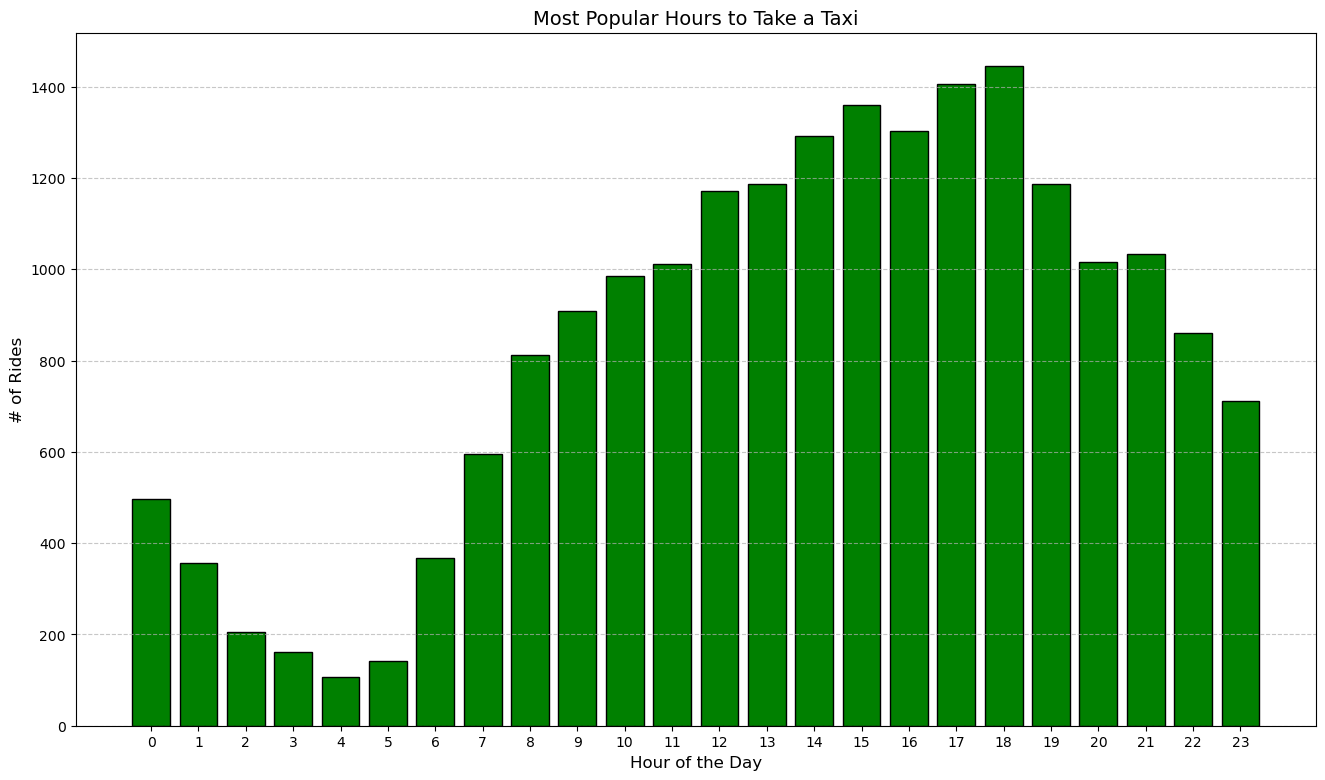

In [64]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)

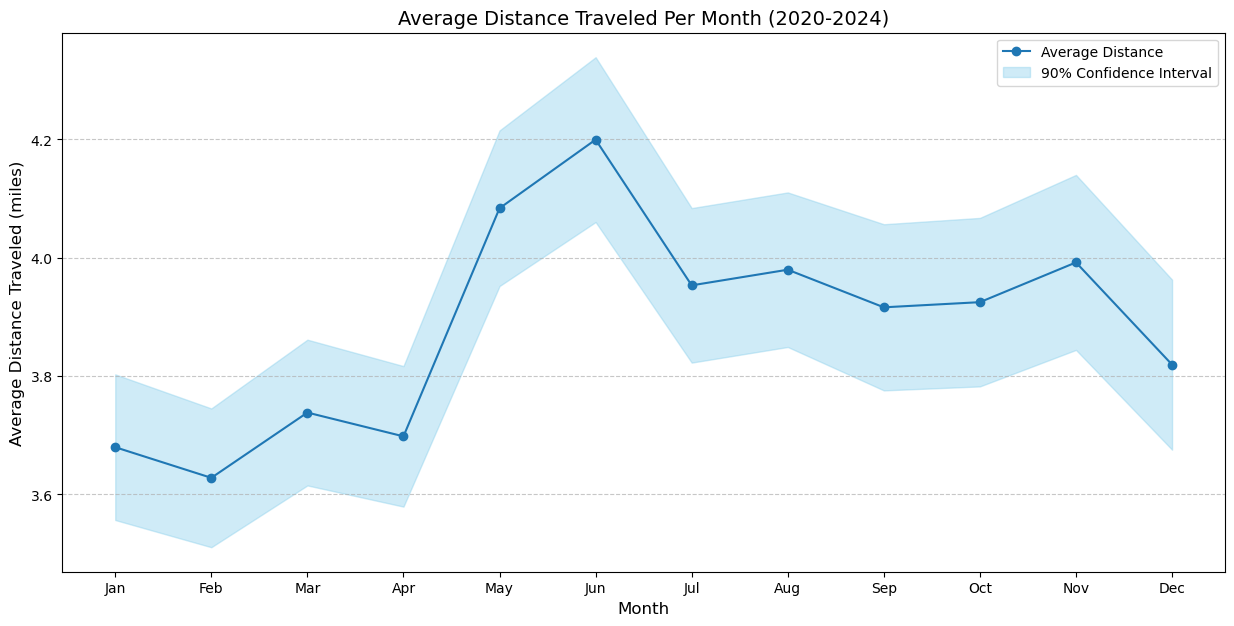

In [65]:
# Function to fetch the data needed for Visualization 2
def get_data_for_visual_2():
    """
    Query the SQL database to get the average distance traveled per month,
    with data grouped by month (irrespective of year) for both taxis and Ubers combined.
    Returns:
        pd.DataFrame: DataFrame containing the month and average distance.
    """
    query = """
    WITH monthly_rides AS (
        SELECT 
            STRFTIME('%m', tpep_pickup_datetime) AS month,
            trip_distance AS distance
        FROM taxi_trips
        WHERE STRFTIME('%Y-%m', tpep_pickup_datetime) BETWEEN '2020-01' AND '2024-08'
        UNION ALL
        SELECT 
            STRFTIME('%m', pickup_datetime) AS month,
            trip_miles AS distance
        FROM uber_trips
        WHERE STRFTIME('%Y-%m', pickup_datetime) BETWEEN '2020-01' AND '2024-08'
    )
    SELECT 
        month,
        distance
    FROM monthly_rides;
    """
    # Execute the query and return the results as a DataFrame
    with engine.connect() as con:
        df = pd.read_sql(query, con)

    return df


# Function to create the visualization
def plot_visual_2(dataframe):
    """
    Create a line chart showing the average distance traveled per month
    with 90% confidence intervals for both taxis and Ubers combined.
    Args:
        dataframe (pd.DataFrame): DataFrame containing month and distance.
    """
    # Convert month to integers for plotting
    dataframe['month'] = dataframe['month'].astype(int)

    # Group by month and calculate mean, standard deviation, and ride count
    grouped = dataframe.groupby('month')['distance'].agg(['mean', 'std', 'count']).reset_index()
    grouped['conf_interval'] = 1.645 * (grouped['std'] / np.sqrt(grouped['count']))  # 90% confidence interval

    # Plot the data
    figure, axes = plt.subplots(figsize=(15, 7))
    axes.plot(grouped['month'], grouped['mean'], marker='o', label='Average Distance')

    # Add confidence interval as a shaded region
    axes.fill_between(
        grouped['month'],
        grouped['mean'] - grouped['conf_interval'],
        grouped['mean'] + grouped['conf_interval'],
        color='skyblue', alpha=0.4, label='90% Confidence Interval'
    )

    # Add labels and title
    axes.set_xlabel('Month', fontsize=12)
    axes.set_ylabel('Average Distance Traveled (miles)', fontsize=12)
    axes.set_title('Average Distance Traveled Per Month (2020-2024)', fontsize=14)
    axes.set_xticks(range(1, 13))
    axes.set_xticklabels(
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
    axes.legend()
    axes.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
# Fetch the data and create the visualization
monthly_distance_data = get_data_for_visual_2()
plot_visual_2(monthly_distance_data)

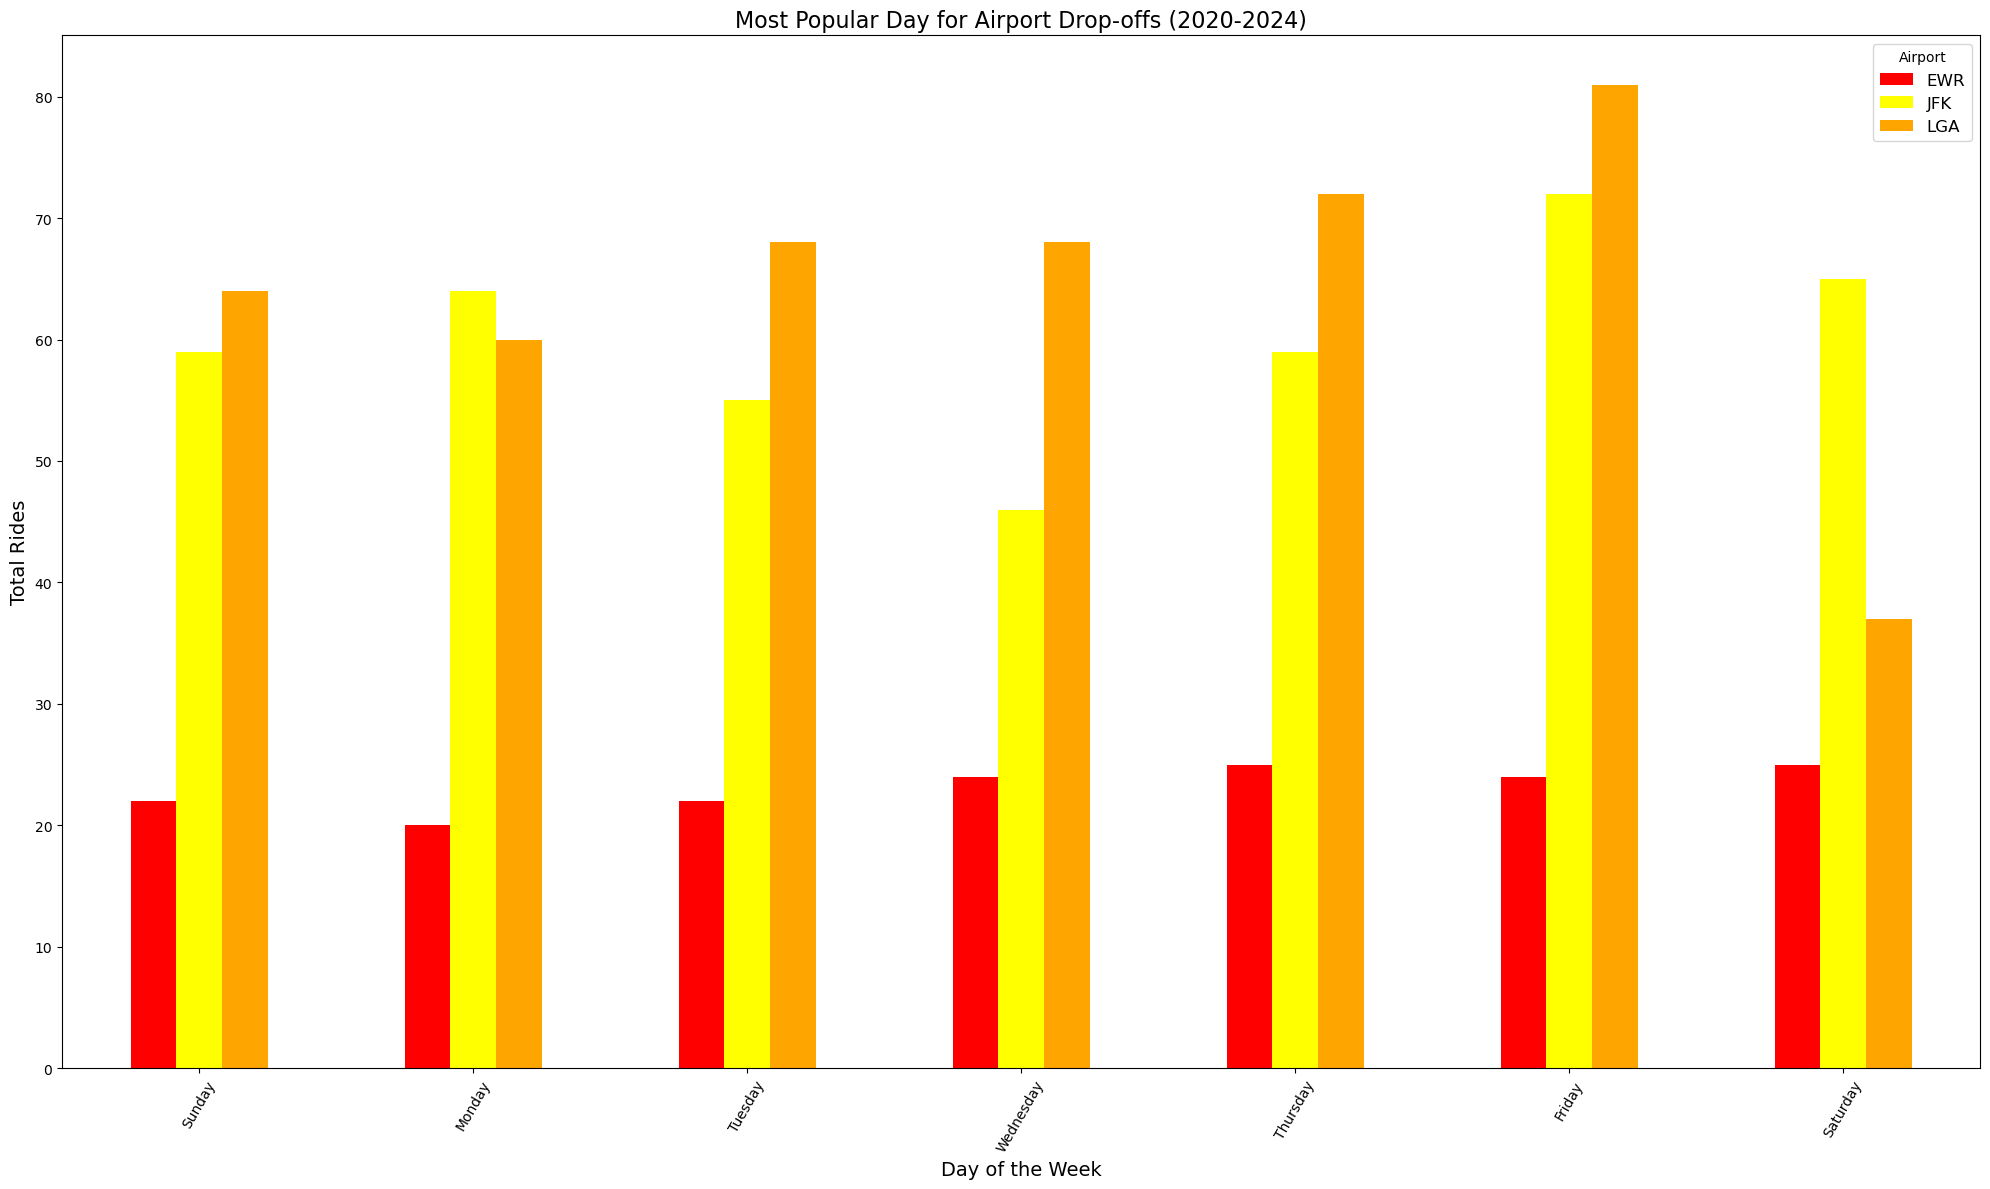

In [66]:
def get_data_for_visual_airport_popular_days():
    """
    Query SQL database for the most popular days of the week for airport drop-offs (LGA, JFK, EWR).
    """
    QUERY = """
    WITH airport_dropoffs AS (
        SELECT 
            STRFTIME('%w', tpep_dropoff_datetime) AS day_of_week,
            'LGA' AS airport
        FROM taxi_trips
        WHERE latitude_dropoff1 BETWEEN 40.766819 AND 40.781359
          AND longitude_dropoff1 BETWEEN -73.889611 AND -73.863849
        UNION ALL
        SELECT 
            STRFTIME('%w', tpep_dropoff_datetime) AS day_of_week,
            'JFK' AS airport
        FROM taxi_trips
        WHERE latitude_dropoff1 BETWEEN 40.633749 AND 40.659658
          AND longitude_dropoff1 BETWEEN -73.819752 AND -73.752762
        UNION ALL
        SELECT 
            STRFTIME('%w', tpep_dropoff_datetime) AS day_of_week,
            'EWR' AS airport
        FROM taxi_trips
        WHERE latitude_dropoff1 BETWEEN 40.689531 AND 40.710844
          AND longitude_dropoff1 BETWEEN -74.190194 AND -74.164609
        UNION ALL
        SELECT 
            STRFTIME('%w', dropoff_datetime) AS day_of_week,
            'LGA' AS airport
        FROM uber_trips
        WHERE latitude_dropoff2 BETWEEN 40.766819 AND 40.781359
          AND longitude_dropoff2 BETWEEN -73.889611 AND -73.863849
        UNION ALL
        SELECT 
            STRFTIME('%w', dropoff_datetime) AS day_of_week,
            'JFK' AS airport
        FROM uber_trips
        WHERE latitude_dropoff2 BETWEEN 40.633749 AND 40.659658
          AND longitude_dropoff2 BETWEEN -73.819752 AND -73.752762
        UNION ALL
        SELECT 
            STRFTIME('%w', dropoff_datetime) AS day_of_week,
            'EWR' AS airport
        FROM uber_trips
        WHERE latitude_dropoff2 BETWEEN 40.689531 AND 40.710844
          AND longitude_dropoff2 BETWEEN -74.190194 AND -74.164609
    )
    SELECT 
        airport,
        day_of_week,
        COUNT(*) AS total_rides
    FROM airport_dropoffs
    GROUP BY airport, day_of_week
    ORDER BY airport, day_of_week;
    """
    # Execute query and return DataFrame
    with engine.connect() as con:
        df = pd.read_sql(QUERY, con)
    return df

def plot_visual_airport_popular_days(dataframe):
    """
    Generate a visualization showing the most popular day of the week for airport drop-offs.
    """
    # Map day_of_week numbers to labels
    day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    dataframe['day_of_week'] = dataframe['day_of_week'].astype(int).map(lambda x: day_labels[x])

    # Pivot data for visualization
    pivot_df = dataframe.pivot(index='day_of_week', columns='airport', values='total_rides')
    pivot_df = pivot_df.reindex(day_labels)  # Ensure correct order of days

    # Plot the data
    import matplotlib.pyplot as plt
    colors = ['red', 'yellow', 'orange']  # Colors for LGA, JFK, and EWR
    ax = pivot_df.plot(kind='bar', figsize=(20, 12), rot=60, color=colors)

    plt.title("Most Popular Day for Airport Drop-offs (2020-2024)", fontsize=16)
    plt.xlabel("Day of the Week", fontsize=14)
    plt.ylabel("Total Rides", fontsize=14)
    plt.legend(title="Airport", fontsize=12)
    plt.tight_layout()
    plt.show()

# Fetch the data and create the visualization
visual_airport_data = get_data_for_visual_airport_popular_days()
plot_visual_airport_popular_days(visual_airport_data)

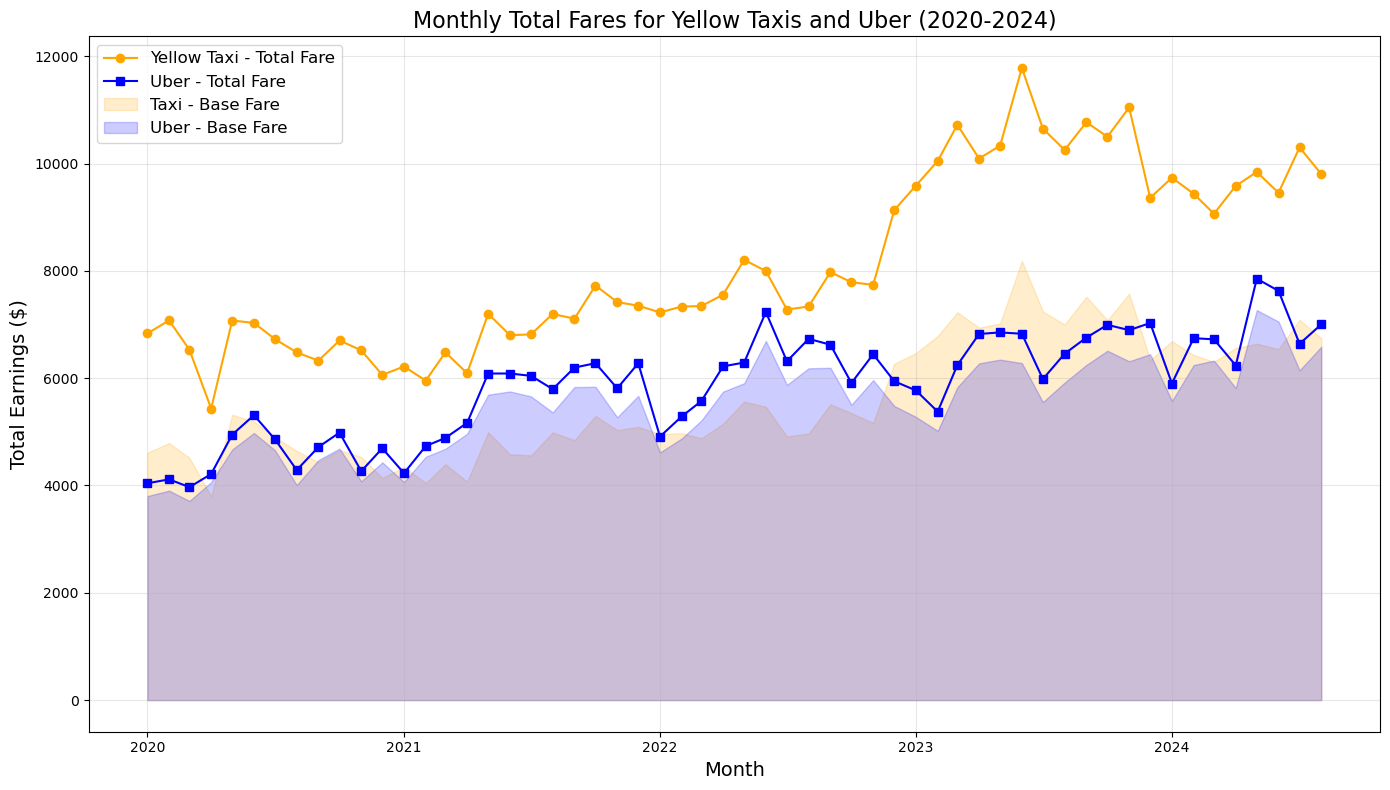

In [67]:
def get_data_for_visual_4():
    """
    Query SQL database for the monthly total fares, including fare components.
    """
    QUERY_4 = """
    WITH taxi_monthly_fares AS (
        SELECT 
            STRFTIME('%Y-%m', tpep_pickup_datetime) AS month,
            SUM(total_amount) AS total_fare,
            SUM(fare_amount) AS base_fare,
            SUM(tip_amount) AS tips,
            SUM(total_amount - fare_amount - tip_amount) AS surcharges_and_tolls
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY STRFTIME('%Y-%m', tpep_pickup_datetime)
    ),
    uber_monthly_fares AS (
        SELECT 
            STRFTIME('%Y-%m', pickup_datetime) AS month,
            SUM(base_passenger_fare + tolls + tips) AS total_fare,
            SUM(base_passenger_fare) AS base_fare,
            SUM(tips) AS tips,
            SUM(tolls) AS surcharges_and_tolls
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY STRFTIME('%Y-%m', pickup_datetime)
    )
    SELECT
        t.month AS month,
        t.total_fare AS taxi_total_fare,
        t.base_fare AS taxi_base_fare,
        t.tips AS taxi_tips,
        t.surcharges_and_tolls AS taxi_surcharges_and_tolls,
        u.total_fare AS uber_total_fare,
        u.base_fare AS uber_base_fare,
        u.tips AS uber_tips,
        u.surcharges_and_tolls AS uber_surcharges_and_tolls
    FROM taxi_monthly_fares t
    LEFT JOIN uber_monthly_fares u ON t.month = u.month
    ORDER BY t.month;
    """
    with engine.connect() as con:
        df = pd.read_sql(QUERY_4, con)
    return df


def plot_visual_4(dataframe):
    """
    Generate a visualization comparing monthly total fares between Yellow Taxis and Uber.
    """
    import matplotlib.pyplot as plt

    # Convert 'month' to datetime for proper sorting
    dataframe['month'] = pd.to_datetime(dataframe['month'])
    dataframe.sort_values(by='month', inplace=True)

    # Plot total fares
    plt.figure(figsize=(14, 8))
    plt.plot(dataframe['month'], dataframe['taxi_total_fare'], label="Yellow Taxi - Total Fare", marker='o', color='orange')
    plt.plot(dataframe['month'], dataframe['uber_total_fare'], label="Uber - Total Fare", marker='s', color='blue')

    # Add additional components
    plt.fill_between(dataframe['month'], dataframe['taxi_base_fare'], alpha=0.2, label="Taxi - Base Fare", color='orange')
    plt.fill_between(dataframe['month'], dataframe['uber_base_fare'], alpha=0.2, label="Uber - Base Fare", color='blue')

    plt.title("Monthly Total Fares for Yellow Taxis and Uber (2020-2024)", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Total Earnings ($)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Fetch the data and create the visualization
visual_4_data = get_data_for_visual_4()
plot_visual_4(visual_4_data)

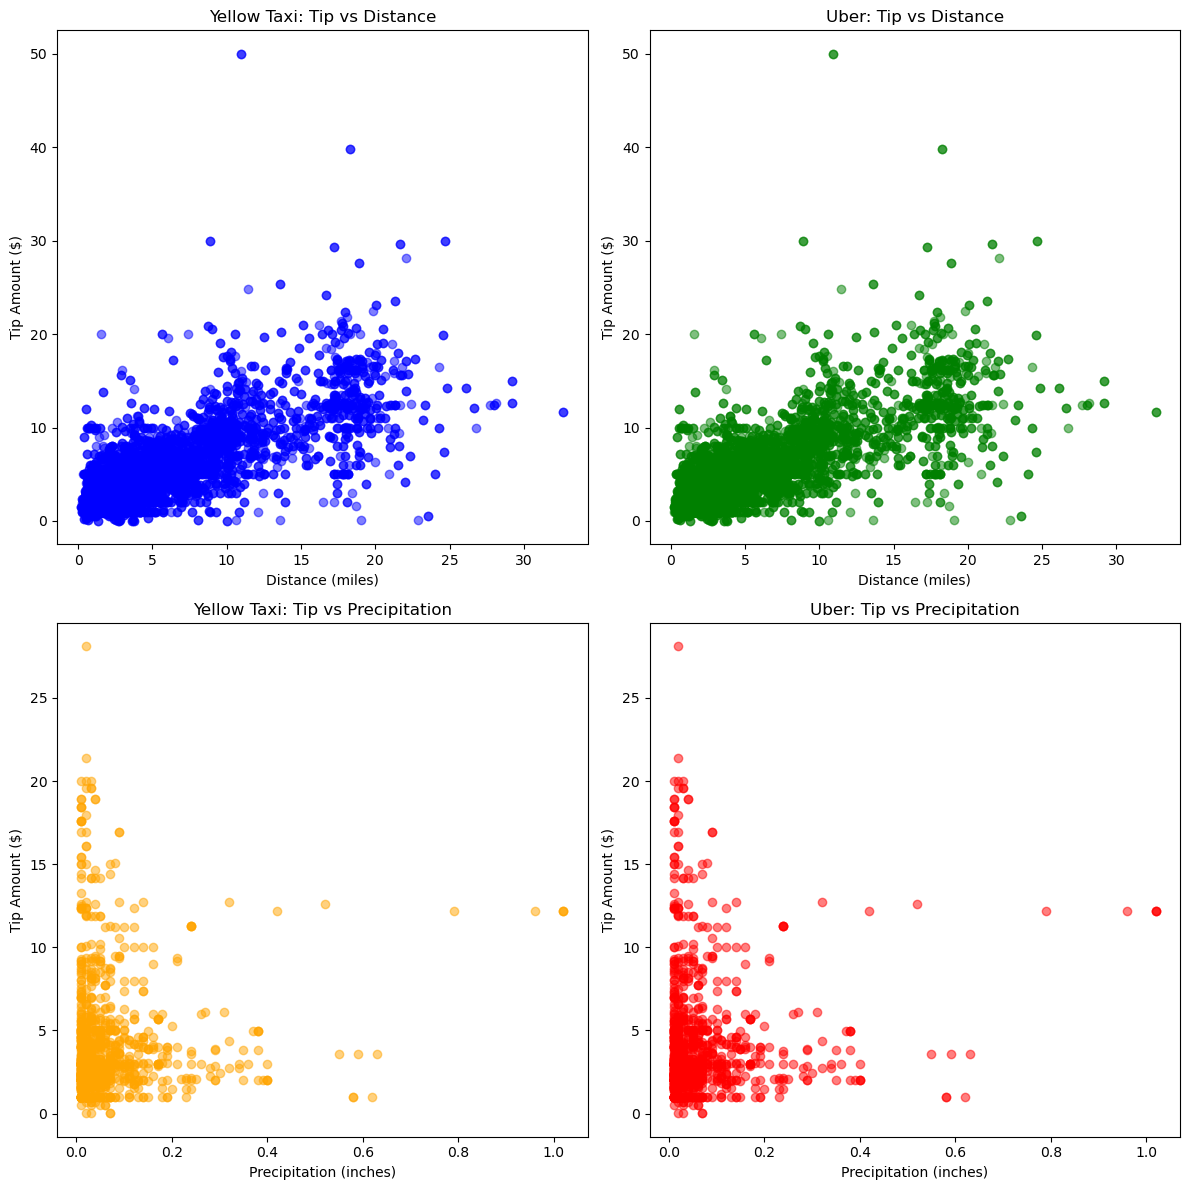

In [68]:
def get_data_for_visual_5():
    """
    Query SQL database to fetch data for visualization 5.
    """
    QUERY_5 = """
    -- Fetch Yellow Taxi data: Tip vs Distance
    WITH yellow_data AS (
        SELECT 
            trip_distance AS distance,
            tip_amount AS tip,
            0 AS precipitation -- Placeholder for precipitation
        FROM taxi_trips
        WHERE STRFTIME('%Y', tpep_pickup_datetime) IN ('2022', '2023')
        AND trip_distance > 0 AND tip_amount > 0
        LIMIT 5000 -- Avoid overloading with large data
    ),
    -- Fetch Uber data: Tip vs Distance
    uber_data AS (
        SELECT 
            trip_miles AS distance,
            tips AS tip,
            0 AS precipitation -- Placeholder for precipitation
        FROM uber_trips
        WHERE STRFTIME('%Y', pickup_datetime) IN ('2022', '2023')
        AND trip_miles > 0 AND tips > 0
        LIMIT 5000
    ),
    -- Fetch Yellow Taxi data: Tip vs Precipitation
    yellow_precip_data AS (
        SELECT 
            trip_distance AS distance,
            tip_amount AS tip,
            hw.precipitation
        FROM taxi_trips tt
        JOIN hourly_weather hw
        ON STRFTIME('%Y-%m-%d %H', tt.tpep_pickup_datetime) = STRFTIME('%Y-%m-%d %H', hw.timestamp)
        WHERE STRFTIME('%Y', tpep_pickup_datetime) IN ('2022', '2023')
        AND trip_distance > 0 AND tip_amount > 0 AND hw.precipitation IS NOT NULL
        LIMIT 5000
    ),
    -- Fetch Uber data: Tip vs Precipitation
    uber_precip_data AS (
        SELECT 
            trip_miles AS distance,
            tips AS tip,
            hw.precipitation
        FROM uber_trips ut
        JOIN hourly_weather hw
        ON STRFTIME('%Y-%m-%d %H', ut.pickup_datetime) = STRFTIME('%Y-%m-%d %H', hw.timestamp)
        WHERE STRFTIME('%Y', pickup_datetime) IN ('2022', '2023')
        AND trip_miles > 0 AND tips > 0 AND hw.precipitation IS NOT NULL
        LIMIT 5000
    )
    -- Combine all data for the final output
    SELECT * FROM yellow_data
    UNION ALL
    SELECT * FROM uber_data
    UNION ALL
    SELECT * FROM yellow_precip_data
    UNION ALL
    SELECT * FROM uber_precip_data;
    """
    # Execute query and return DataFrame
    with engine.connect() as con:
        df = pd.read_sql(QUERY_5, con)
    return df

def plot_visual_5(dataframe):
    """
    Create a 2x2 scatter plot grid to visualize the relationship between tips and distance/precipitation.
    """
    # Filter data for each category
    yellow_distance = dataframe[dataframe['precipitation'] == 0][['distance', 'tip']].dropna()
    uber_distance = dataframe[dataframe['precipitation'] == 0][['distance', 'tip']].dropna()
    yellow_precipitation = dataframe[dataframe['precipitation'] > 0][['precipitation', 'tip']].dropna()
    uber_precipitation = dataframe[dataframe['precipitation'] > 0][['precipitation', 'tip']].dropna()

    # Create a 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Yellow Taxi: Tip vs Distance
    axes[0, 0].scatter(yellow_distance['distance'], yellow_distance['tip'], alpha=0.5, color='blue')
    axes[0, 0].set_title("Yellow Taxi: Tip vs Distance")
    axes[0, 0].set_xlabel("Distance (miles)")
    axes[0, 0].set_ylabel("Tip Amount ($)")

    # Uber: Tip vs Distance
    axes[0, 1].scatter(uber_distance['distance'], uber_distance['tip'], alpha=0.5, color='green')
    axes[0, 1].set_title("Uber: Tip vs Distance")
    axes[0, 1].set_xlabel("Distance (miles)")
    axes[0, 1].set_ylabel("Tip Amount ($)")

    # Yellow Taxi: Tip vs Precipitation
    axes[1, 0].scatter(yellow_precipitation['precipitation'], yellow_precipitation['tip'], alpha=0.5, color='orange')
    axes[1, 0].set_title("Yellow Taxi: Tip vs Precipitation")
    axes[1, 0].set_xlabel("Precipitation (inches)")
    axes[1, 0].set_ylabel("Tip Amount ($)")

    # Uber: Tip vs Precipitation
    axes[1, 1].scatter(uber_precipitation['precipitation'], uber_precipitation['tip'], alpha=0.5, color='red')
    axes[1, 1].set_title("Uber: Tip vs Precipitation")
    axes[1, 1].set_xlabel("Precipitation (inches)")
    axes[1, 1].set_ylabel("Tip Amount ($)")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Fetch data and plot
visual_5_data = get_data_for_visual_5()
plot_visual_5(visual_5_data)

In [69]:
import folium
from folium.plugins import HeatMap
import pandas as pd

def get_data_for_visual_6():
    """
    Query SQL database for all hired trips in 2020, retrieving drop-off coordinates.
    """
    QUERY_6 = """
    SELECT 
        latitude_dropoff1 AS latitude,
        longitude_dropoff1 AS longitude
    FROM taxi_trips
    WHERE STRFTIME('%Y', tpep_dropoff_datetime) = '2020'
    AND latitude_dropoff1 IS NOT NULL AND longitude_dropoff1 IS NOT NULL
    UNION ALL
    SELECT 
        latitude_dropoff2 AS latitude,
        longitude_dropoff2 AS longitude
    FROM uber_trips
    WHERE STRFTIME('%Y', dropoff_datetime) = '2020'
    AND latitude_dropoff2 IS NOT NULL AND longitude_dropoff2 IS NOT NULL;
    """
    # Execute query and return DataFrame
    with engine.connect() as con:
        df = pd.read_sql(QUERY_6, con)
    return df

def plot_visual_6(dataframe):
    """
    Create a heatmap of all hired trips in 2020 using Folium.
    """
    # Initialize a base map centered around NYC
    map_center = [40.7128, -74.0060]  # Approximate center of NYC
    heatmap_map = folium.Map(location=map_center, zoom_start=11)

    # Prepare data for the heatmap (latitude, longitude pairs)
    heatmap_data = dataframe[['latitude', 'longitude']].dropna().values.tolist()

    # Add HeatMap layer
    HeatMap(heatmap_data, radius=8, blur=15, max_zoom=1).add_to(heatmap_map)

    # Save map to an HTML file
    heatmap_map.save("heatmap_nyc_2020.html")
    print("Heatmap saved to 'heatmap_nyc_2020.html'.")

    return heatmap_map

# Fetch data and generate the heatmap
visual_6_data = get_data_for_visual_6()
heatmap = plot_visual_6(visual_6_data)

# Display map (this works in Jupyter Notebook)
heatmap

Heatmap saved to 'heatmap_nyc_2020.html'.
